#Part 1 — Introduction

## Decision Tree Classifier (From Scratch) — Bank Marketing Dataset

The **Bank Marketing dataset** contains information about clients and whether they subscribed to a term deposit.  

We will implement a **Decision Tree Classifier from scratch** to predict the target (`yes`/`no`).  

### Key Intuition
- Decision Trees **recursively split** the dataset based on features to reduce impurity.  
- At each node, we select the **best feature and threshold** using metrics like:
  - **Gini Index** → probability of misclassification  
  - **Entropy (Information Gain)** → uncertainty in the node  

### Goals
- Implement **impurity measures**  
- Build a **recursive tree from scratch**  
- Implement **prediction function**  
- Compare **scratch implementation with scikit-learn**  
- Evaluate **accuracy, F1-score, and visualize decision boundaries**  
- Apply **regularization** (max_depth, min_samples_split) to prevent overfitting  


#Part 2 — Import Libraries & Load Data

In [1]:
import pandas as pd
import numpy as np

# Load separate train and test datasets
train_df = pd.read_csv("train.csv", sep=';')
test_df = pd.read_csv("test.csv", sep=';')

print("Train dataset shape:", train_df.shape)
print("Test dataset shape :", test_df.shape)

# Convert target to numeric
train_df['y'] = train_df['y'].map({'yes':1, 'no':0})
test_df['y'] = test_df['y'].map({'yes':1, 'no':0})

# Identify categorical columns (excluding target)
categorical_cols = [col for col in train_df.select_dtypes(include=['object']).columns if col != 'y']

# One-hot encode categorical features
train_df_encoded = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)
test_df_encoded = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)

# Align columns (ensure test has same columns as train)
X_train = train_df_encoded.drop('y', axis=1)
X_test  = test_df_encoded.drop('y', axis=1)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)  # fill missing columns with 0
y_train = train_df_encoded['y'].values
y_test  = test_df_encoded['y'].values

# Convert to numpy arrays
X_train = X_train.values
X_test = X_test.values

print("Training samples:", X_train.shape[0])
print("Testing samples :", X_test.shape[0])


Train dataset shape: (45211, 17)
Test dataset shape : (4521, 17)
Training samples: 45211
Testing samples : 4521


Steps:
1. Load **train.csv** and **test.csv** separately.  
2. Inspect data: numeric and categorical features.  
3. Preprocess categorical features (one-hot encoding).  
4. Convert target to numeric (`yes=1, no=0`).  


#Part 3 — Define Impurity Measures (Gini & Entropy)

In [2]:
def gini_index(y):
    classes, counts = np.unique(y, return_counts=True)
    prob_sq_sum = np.sum((counts / counts.sum()) ** 2)
    return 1 - prob_sq_sum

def entropy(y):
    classes, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs + 1e-9))  # add epsilon to avoid log(0)

# Test on small sample
sample_y = np.array([1,0,0,1,1,0,1])
print("Sample labels:", sample_y)
print("Gini Index:", gini_index(sample_y))
print("Entropy:", entropy(sample_y))


Sample labels: [1 0 0 1 1 0 1]
Gini Index: 0.48979591836734704
Entropy: 0.9852281331488615


At each split, we calculate **impurity** to find the best feature and threshold.  

### Gini Index
Measures **probability of incorrect classification** if we randomly assign a label at a node.

$$ Gini = 1 - \sum_{i=1}^{k} p_i^2 $$

- $p_i$ = fraction of class $i$ in the node  
- $Gini=0$ → perfectly pure  
- Higher Gini → more mixed classes  

### Entropy
Measures **uncertainty** in the node.

$$ Entropy = -\sum_{i=1}^{k} p_i \log_2(p_i) $$

- $Entropy=0$ → pure node  
- Higher entropy → more disorder

We will implement both as Python functions.


#Part 4 — Define Tree Node Structure


In [3]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.is_leaf = value is not None


Each node in a decision tree contains:

- `feature_index` → index of the feature used for splitting  
- `threshold` → numeric threshold for splitting  
- `left` → left child node (samples <= threshold)  
- `right` → right child node (samples > threshold)  
- `value` → class label (only for leaf nodes)  
- `is_leaf` → boolean flag to indicate if it’s a leaf node  

Leaf nodes store **majority class** of samples reaching that node.


# Part 5 — Define Best Split Function

In [4]:
def best_split(X, y, criterion="gini"):
    n_samples, n_features = X.shape
    best_feature, best_threshold, best_score = None, None, float('inf')

    # Loop over features
    for feature_idx in range(n_features):
        thresholds = np.unique(X[:, feature_idx])
        for t in thresholds:
            left_idx = np.where(X[:, feature_idx] <= t)[0]
            right_idx = np.where(X[:, feature_idx] > t)[0]

            if len(left_idx) == 0 or len(right_idx) == 0:
                continue

            y_left, y_right = y[left_idx], y[right_idx]

            # Weighted impurity
            if criterion == "gini":
                score = (len(y_left)*gini_index(y_left) + len(y_right)*gini_index(y_right)) / n_samples
            else:  # entropy
                score = (len(y_left)*entropy(y_left) + len(y_right)*entropy(y_right)) / n_samples

            if score < best_score:
                best_score = score
                best_feature = feature_idx
                best_threshold = t

    return best_feature, best_threshold, best_score


At each node, we evaluate **all features** and **possible thresholds** to find the split that **minimizes impurity**.

Steps:
1. Loop over each feature.  
2. Loop over unique values of the feature (as candidate thresholds).  
3. Split data into left/right groups.  
4. Compute **weighted impurity** (Gini or Entropy).  
5. Select feature and threshold with **lowest impurity**.

Output:
- `best_feature_index` → index of the chosen feature  
- `best_threshold` → value for splitting  
- `best_score` → impurity score of the split


# Part 6 — Build the Decision Tree (Recursive)

In [5]:
def build_tree(X, y, depth=0, max_depth=5, min_samples_split=10, criterion="gini"):
    # If all labels are same → leaf
    if len(np.unique(y)) == 1:
        return Node(value=np.unique(y)[0])

    # Stopping conditions
    if depth >= max_depth or X.shape[0] < min_samples_split:
        majority_class = np.bincount(y).argmax()
        return Node(value=majority_class)

    # Find best split
    feature_idx, threshold, score = best_split(X, y, criterion)

    # If no split is found
    if feature_idx is None:
        majority_class = np.bincount(y).argmax()
        return Node(value=majority_class)

    # Split data
    left_idx = np.where(X[:, feature_idx] <= threshold)[0]
    right_idx = np.where(X[:, feature_idx] > threshold)[0]

    left_child = build_tree(X[left_idx, :], y[left_idx], depth+1, max_depth, min_samples_split, criterion)
    right_child = build_tree(X[right_idx, :], y[right_idx], depth+1, max_depth, min_samples_split, criterion)

    return Node(feature_index=feature_idx, threshold=threshold, left=left_child, right=right_child)


Recursive procedure:

1. **Stopping Conditions**:
   - All labels are the same → make leaf  
   - Max depth reached → make leaf  
   - Node has fewer than `min_samples_split` samples → make leaf  

2. **Find best split** (Part 5)  
3. Split data into left/right  
4. Recursively build left and right child nodes  
5. Return root node of tree  

Parameters:
- `max_depth` → limit tree depth  
- `min_samples_split` → minimum samples to allow a split  
- `criterion` → "gini" or "entropy"


#Part 7 — Prediction Function

In [6]:
# Predict single sample
def predict_single(x, node):
    if node.is_leaf:
        return node.value
    if x[node.feature_index] <= node.threshold:
        return predict_single(x, node.left)
    else:
        return predict_single(x, node.right)

# Predict multiple samples
def predict(X, tree):
    return np.array([predict_single(x, tree) for x in X])


To make predictions with a trained tree, we **traverse the tree recursively**:

1. Start at the root node  
2. If the node is a **leaf**, return its class label  
3. Else, compare the feature value of the sample with the node's threshold:
   - If `x[feature_index] <= threshold` → go left  
   - Else → go right  
4. Repeat until reaching a leaf node


#Part 8 — Train the Scratch Tree on Bank Marketing

In [7]:
# Build the tree
scratch_tree = build_tree(
    X_train, y_train,
    max_depth=5,          # regularization
    min_samples_split=50, # regularization
    criterion="gini"
)

# Predict on training set
y_train_pred_scratch = predict(X_train, scratch_tree)
y_test_pred_scratch  = predict(X_test, scratch_tree)

print("Scratch tree trained successfully!")


Scratch tree trained successfully!


Steps:
1. Set **max_depth** and **min_samples_split** to control overfitting  
2. Build tree using `build_tree`  
3. Print confirmation and optional tree structure (recursive print)  


#Part 9 — Compare with scikit-learn DecisionTreeClassifier

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

# Initialize sklearn tree with same hyperparameters
clf = DecisionTreeClassifier(
    criterion="gini",
    max_depth=5,
    min_samples_split=50,
    random_state=42
)

# Train
clf.fit(X_train, y_train)

# Predict
y_train_pred_sklearn = clf.predict(X_train)
y_test_pred_sklearn  = clf.predict(X_test)

# Metrics
print("Scratch Tree - Train Accuracy:", accuracy_score(y_train, y_train_pred_scratch))
print("Scratch Tree - Test Accuracy :", accuracy_score(y_test, y_test_pred_scratch))
print("\n")

print("Sklearn Tree - Train Accuracy:", accuracy_score(y_train, y_train_pred_sklearn))
print("Sklearn Tree - Test Accuracy :", accuracy_score(y_test, y_test_pred_sklearn))
print("\n")

print("Scratch Tree - Test F1 Score :", f1_score(y_test, y_test_pred_scratch))
print("Sklearn Tree - Test F1 Score  :", f1_score(y_test, y_test_pred_sklearn))


Scratch Tree - Train Accuracy: 0.9037402402070293
Scratch Tree - Test Accuracy : 0.9046671090466711


Sklearn Tree - Train Accuracy: 0.9037402402070293
Sklearn Tree - Test Accuracy : 0.9046671090466711


Scratch Tree - Test F1 Score : 0.45095541401273886
Sklearn Tree - Test F1 Score  : 0.45095541401273886


Steps:
1. Train `DecisionTreeClassifier` with same **max_depth** and **min_samples_split**  
2. Predict on train and test sets  
3. Compare **accuracy and F1-score**


# Part 10 — Accuracy & F1 Comparison with Baseline

In [9]:
from sklearn.metrics import classification_report

# Baseline (majority class)
majority_class = np.bincount(y_train).argmax()
y_train_baseline = np.full_like(y_train, majority_class)
y_test_baseline  = np.full_like(y_test, majority_class)

print("Baseline Accuracy - Train:", accuracy_score(y_train, y_train_baseline))
print("Baseline Accuracy - Test :", accuracy_score(y_test, y_test_baseline))

# Detailed report for scratch tree
print("\nScratch Tree Classification Report (Test):")
print(classification_report(y_test, y_test_pred_scratch))

# Detailed report for sklearn tree
print("\nSklearn Tree Classification Report (Test):")
print(classification_report(y_test, y_test_pred_sklearn))


Baseline Accuracy - Train: 0.8830151954170445
Baseline Accuracy - Test : 0.8847600088476001

Scratch Tree Classification Report (Test):
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4000
           1       0.67      0.34      0.45       521

    accuracy                           0.90      4521
   macro avg       0.79      0.66      0.70      4521
weighted avg       0.89      0.90      0.89      4521


Sklearn Tree Classification Report (Test):
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4000
           1       0.67      0.34      0.45       521

    accuracy                           0.90      4521
   macro avg       0.79      0.66      0.70      4521
weighted avg       0.89      0.90      0.89      4521



1. **Baseline**: predict the **majority class** for all samples  
2. Compare **scratch tree**, **sklearn tree**, and **baseline** on train/test  
3. Metrics:  
   - Accuracy  
   - F1-score (important for imbalanced datasets)


#Part 11 — Visualize Decision Boundaries (2 Features)

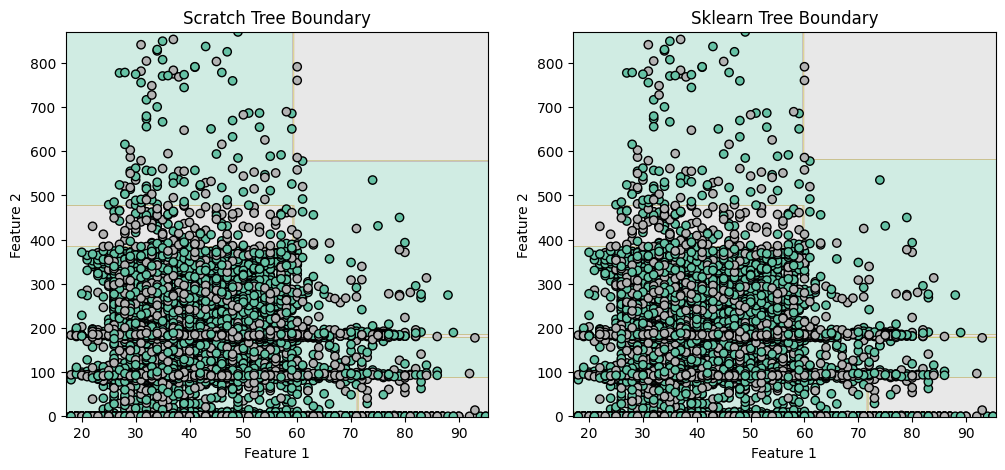

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Choose 2 features for visualization (change indices if needed)
feature_indices = [0, 5]  # e.g., age, duration
X_train_vis = X_train[:, feature_indices]
X_test_vis  = X_test[:, feature_indices]

# Rebuild trees on 2 features for visualization
tree_scratch_vis = build_tree(X_train_vis, y_train, max_depth=5, min_samples_split=50)
clf_vis = DecisionTreeClassifier(max_depth=5, min_samples_split=50, random_state=42)
clf_vis.fit(X_train_vis, y_train)

def plot_boundary(X, y, tree, title, scratch=True):
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5),
                         np.arange(y_min, y_max, 0.5))
    grid = np.c_[xx.ravel(), yy.ravel()]

    if scratch:
        Z = predict(grid, tree)  # scratch tree
    else:
        Z = tree.predict(grid)   # sklearn tree

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="Set2")
    plt.scatter(X[:,0], X[:,1], c=y, cmap="Set2", edgecolor="k")
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_boundary(X_train_vis, y_train, tree_scratch_vis, "Scratch Tree Boundary", scratch=True)
plt.subplot(1,2,2)
plot_boundary(X_train_vis, y_train, clf_vis, "Sklearn Tree Boundary", scratch=False)
plt.show()


1. Select **2 numeric features** for visualization, e.g., `duration` & `age`  
2. Plot predicted regions for:  
   - Scratch tree  
   - Sklearn tree  
3. Observe effects of **max_depth & min_samples_split** on boundaries


# Part 12 — Print Tree Structure (Optional)

In [11]:
def print_tree(node, feature_names=None, depth=0):
    prefix = "  " * depth
    if node.is_leaf:
        print(f"{prefix}Leaf: Class={node.value}")
    else:
        feature_name = feature_names[node.feature_index] if feature_names else f"X{node.feature_index}"
        print(f"{prefix}[{feature_name} <= {node.threshold:.2f}]")
        print_tree(node.left, feature_names, depth+1)
        print(f"{prefix}[{feature_name} > {node.threshold:.2f}]")
        print_tree(node.right, feature_names, depth+1)

# Example (show top 2 levels for readability)
print_tree(scratch_tree, depth=2)


    [X3 <= 521.00]
      [X40 <= 0.00]
        [X3 <= 206.00]
          [X34 <= 0.00]
            [X37 <= 0.00]
              Leaf: Class=0
            [X37 > 0.00]
              Leaf: Class=0
          [X34 > 0.00]
            [X3 <= 105.00]
              Leaf: Class=0
            [X3 > 105.00]
              Leaf: Class=0
        [X3 > 206.00]
          [X24 <= 0.00]
            [X0 <= 60.00]
              Leaf: Class=0
            [X0 > 60.00]
              Leaf: Class=0
          [X24 > 0.00]
            [X5 <= 374.00]
              Leaf: Class=0
            [X5 > 374.00]
              Leaf: Class=1
      [X40 > 0.00]
        [X3 <= 162.00]
          [X3 <= 132.00]
            [X3 <= 79.00]
              Leaf: Class=0
            [X3 > 79.00]
              Leaf: Class=0
          [X3 > 132.00]
            [X3 <= 155.00]
              Leaf: Class=1
            [X3 > 155.00]
              Leaf: Class=0
        [X3 > 162.00]
          [X5 <= 202.00]
            [X5 <= 41.00]
          

A **text-based recursive tree printout** helps understand:
- Which features are used at top levels  
- Thresholds  
- Depth of tree


#Part 13 — Regularization Effects

In [12]:
depths = [3, 5, 10]
min_samples = [10, 50, 200]

for d in depths:
    for m in min_samples:
        tree = build_tree(X_train, y_train, max_depth=d, min_samples_split=m)
        y_test_pred = predict(X_test, tree)
        acc = accuracy_score(y_test, y_test_pred)
        print(f"max_depth={d}, min_samples_split={m} => Test Accuracy: {acc:.4f}")


max_depth=3, min_samples_split=10 => Test Accuracy: 0.9020
max_depth=3, min_samples_split=50 => Test Accuracy: 0.9020
max_depth=3, min_samples_split=200 => Test Accuracy: 0.9020
max_depth=5, min_samples_split=10 => Test Accuracy: 0.9047
max_depth=5, min_samples_split=50 => Test Accuracy: 0.9047
max_depth=5, min_samples_split=200 => Test Accuracy: 0.9036
max_depth=10, min_samples_split=10 => Test Accuracy: 0.9255
max_depth=10, min_samples_split=50 => Test Accuracy: 0.9199
max_depth=10, min_samples_split=200 => Test Accuracy: 0.9151


1. **max_depth** → limit tree depth to prevent overfitting  
2. **min_samples_split** → require minimum samples to split a node  

Effect:
- Smaller max_depth → smoother decision boundaries  
- Larger min_samples_split → avoids tiny splits for outliers  

Experiment by changing these parameters and observing:
- Train vs Test accuracy  
- Decision boundary smoothness


# Part 14 — Advanced Visualizations

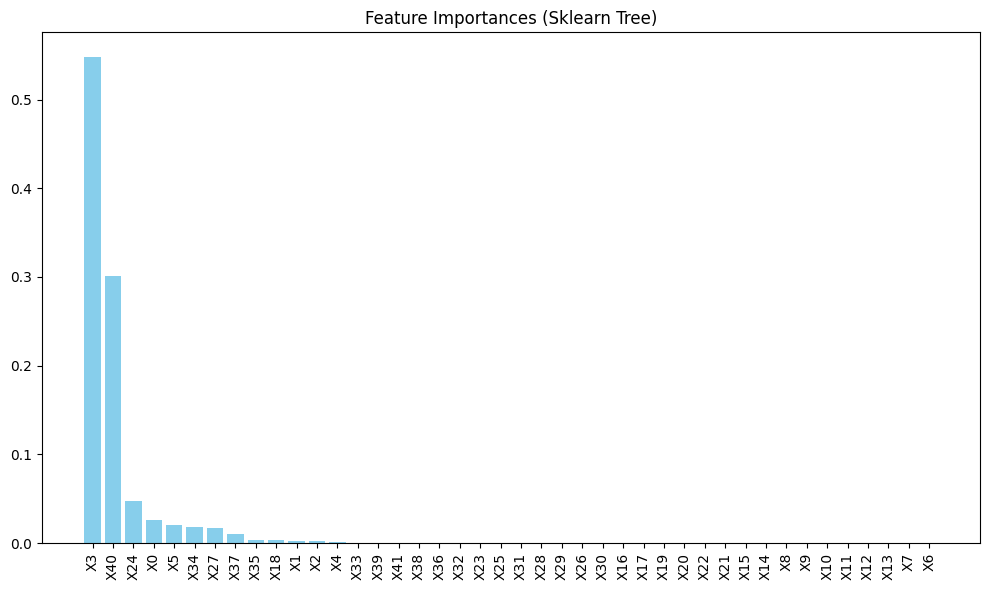

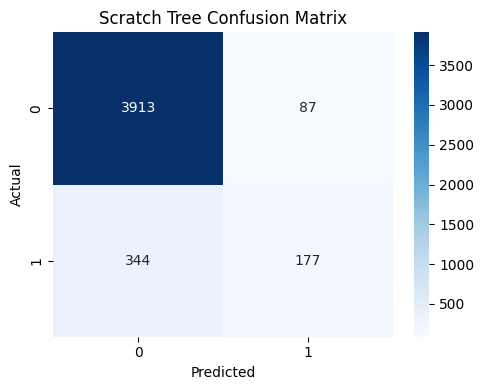

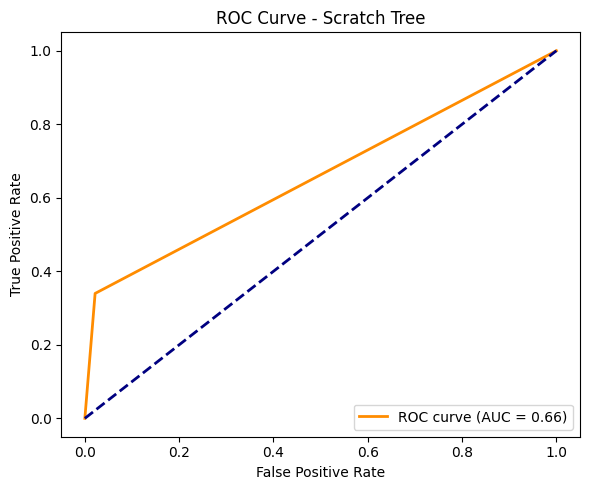

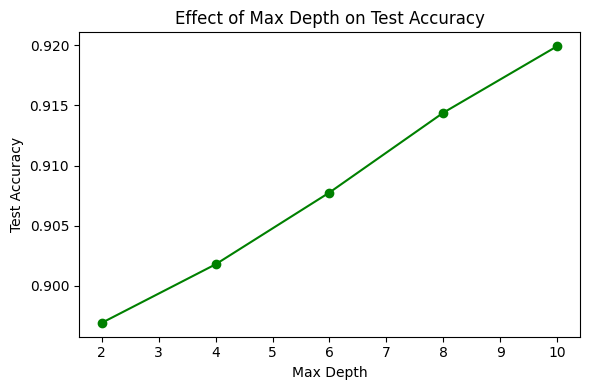

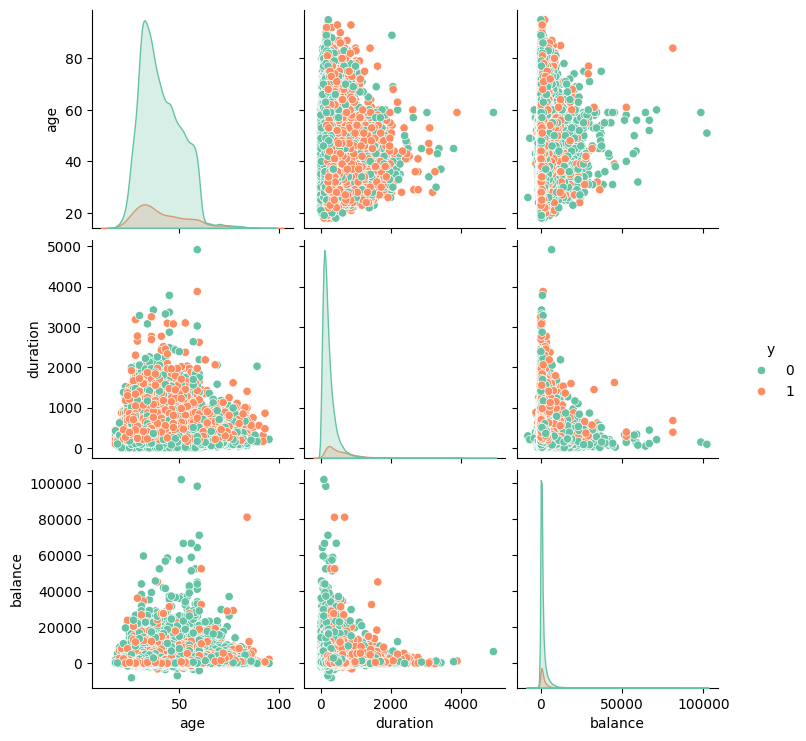

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# -------------------------
# 1️⃣ Feature Importance (Sklearn Tree)
# -------------------------
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importances (Sklearn Tree)")
plt.bar(range(X_train.shape[1]), importances[indices], color="skyblue")
plt.xticks(range(X_train.shape[1]), [f"X{i}" for i in indices], rotation=90)
plt.tight_layout()
plt.show()
print("\n")  # Add extra space

# -------------------------
# 2️⃣ Confusion Matrix (Scratch Tree)
# -------------------------
cm = confusion_matrix(y_test, y_test_pred_scratch)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Scratch Tree Confusion Matrix")
plt.tight_layout()
plt.show()
print("\n")

# -------------------------
# 3️⃣ ROC Curve / AUC (Scratch Tree)
# -------------------------
y_score = y_test_pred_scratch
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Scratch Tree")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
print("\n")

# -------------------------
# 4️⃣ Depth vs Accuracy
# -------------------------
depths = [2, 4, 6, 8, 10]
test_acc = []

for d in depths:
    tree = build_tree(X_train, y_train, max_depth=d, min_samples_split=50)
    y_pred = predict(X_test, tree)
    test_acc.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(6,4))
plt.plot(depths, test_acc, marker='o', color='green')
plt.xlabel("Max Depth")
plt.ylabel("Test Accuracy")
plt.title("Effect of Max Depth on Test Accuracy")
plt.tight_layout()
plt.show()
print("\n")

# -------------------------
# 5️⃣ Pairplot of Numeric Features
# -------------------------
numeric_features = ['age','duration','balance']  # select 2-3 numeric features
sns.pairplot(train_df, vars=numeric_features, hue='y', palette='Set2')
plt.show()
print("\n")


To make the analysis more **informative and visually appealing**, we include:

1. **Feature Importance** — shows which features contribute most to the model's decision.  
2. **Confusion Matrix** — visualizes true vs predicted labels.  
3. **ROC Curve & AUC** — evaluates classification performance for binary classes.  
4. **Depth vs Accuracy Plot** — shows how regularization (max_depth) affects test accuracy.  
5. **Pairplot of Features** — visualizes relationships between numeric features and target classes.
